In [76]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [77]:
images = glob('/content/train_cancer/*/*.jpg')
len(images)

270

In [78]:
images = [path.replace('\\','/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[3]
df.head()

,filepath,label
0,/content/train_cancer/benign/21.jpg,benign
1,/content/train_cancer/benign/6.jpg,benign
2,/content/train_cancer/benign/20.jpg,benign
3,/content/train_cancer/benign/28.jpg,benign
4,/content/train_cancer/benign/35.jpg,benign


In [79]:
# Let's label the target classes
df['label_bin'] = df['label'].map({'malignant':1, 'benign':0})

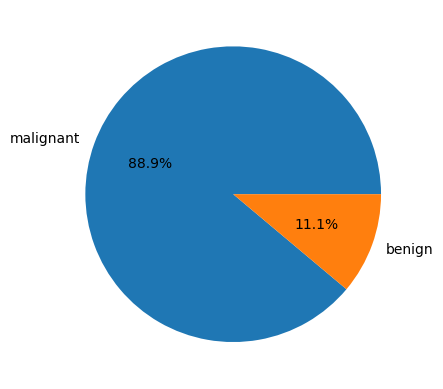

In [80]:
x = df['label'].value_counts()
plt.pie(x.values, labels=x.index, autopct='%1.1f%%')
plt.show()

* It is heavily imbalanced.
* We will be fixing it later

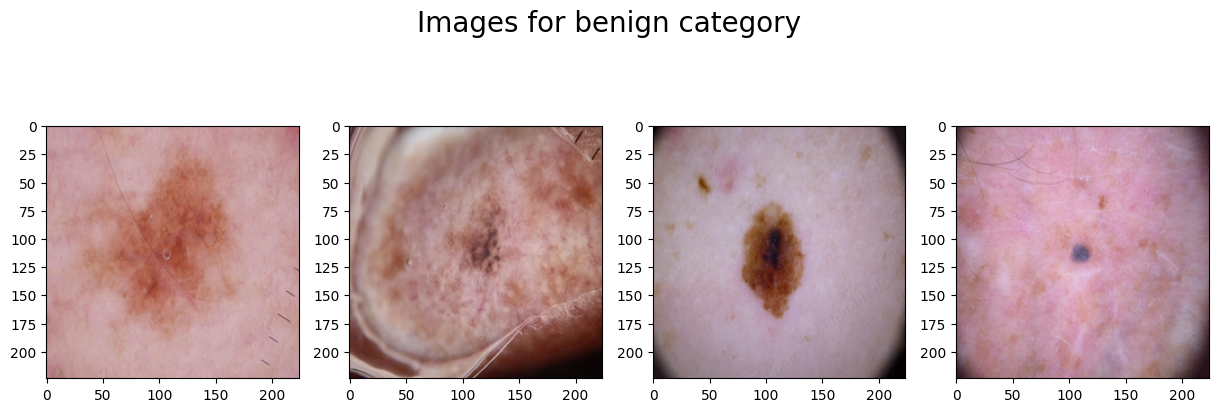

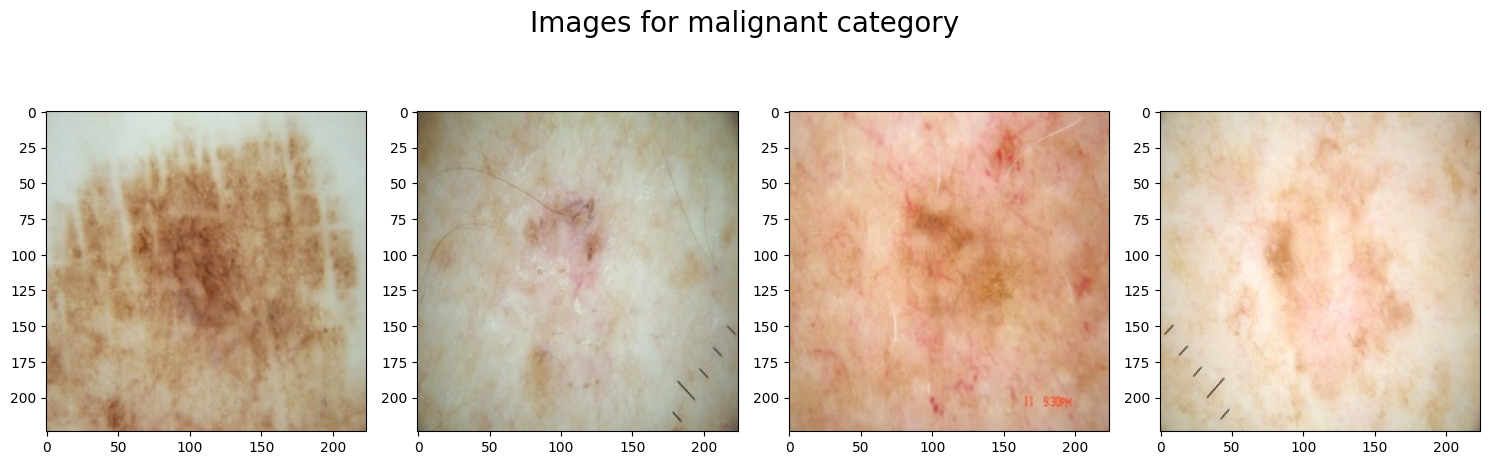

In [43]:
# Let's get the sample images

for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)

    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [83]:
x = df['filepath']
y = df['label_bin']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [84]:
# Ensure labels are NumPy arrays
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [85]:
def decode_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure it's RGB
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize image

    label = tf.cast(label, tf.float32)  # Ensure label is float32

    return img, label

In [86]:
# building image pipelines
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

test = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [88]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras import Model

base_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
base_model.trainable = False  # Freeze pre-trained layers

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass input through EfficientNet
x = layers.GlobalAveragePooling2D()(x)  # Pooling layer
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary output

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,753,560 (247.02 MB)

 Trainable params: 655,873 (2.50 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [89]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # No logits
    optimizer='adam',
    metrics=['AUC']
)

In [90]:
# Setting up weights to each class so the dataset is not imbalanced
from sklearn.utils.class_weight import compute_class_weight

# Computing class weight
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.array([0, 1]),            # 0-Benign, 1-Malignant
    y = y_train
)

# Convert Dictionary to tensorflow
class_weight_dict = {i: class_weights[i] for i in range(len(class_labels))}
print("Class Weights: ", class_weight_dict)

Class Weights:  {0: 4.58, 1: 0.5612745098039216}


In [92]:
history = model.fit(
    train,
    validation_data = test,
    epochs = 5,
    verbose = 1,
    class_weight = class_weight_dict
    )

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 129s 13s/step - AUC: 0.3548 - loss: 0.8962 - val_AUC: 0.5139 - val_loss: 0.8447
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 12s/step - AUC: 0.5211 - loss: 0.7458 - val_AUC: 0.5611 - val_loss: 0.6594
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 12s/step - AUC: 0.5847 - loss: 0.7092 - val_AUC: 0.5000 - val_loss: 0.6438
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - AUC: 0.5531 - loss: 0.7236 - val_AUC: 0.5000 - val_loss: 0.7693
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - AUC: 0.3833 - loss: 0.7988 - val_AUC: 0.5000 - val_loss: 0.7542


In [93]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.388137,0.843283,0.513889,0.844702
1,0.510000,0.733988,0.561111,0.659415
2,0.559608,0.722975,0.500000,0.643780
3,0.433922,0.767791,0.500000,0.769341
4,0.437157,0.767189,0.500000,0.754231


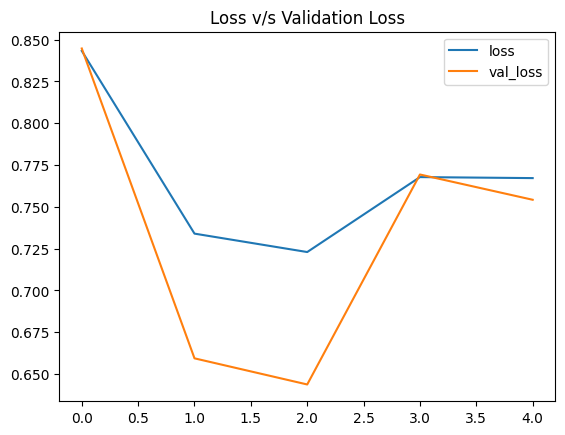

In [94]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

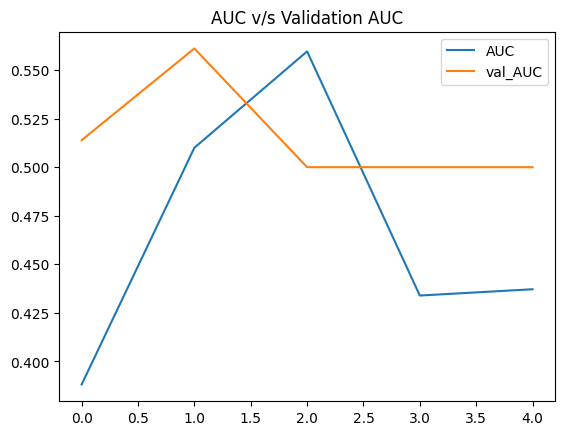

In [95]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()

Thank you for going through this till the end, feel free to get in toch if you have any question... :)